In [5]:
import pandas as pd
import numpy as np

#NLP tools
import regex
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from nltk import sent_tokenize
from nltk.stem.lancaster import LancasterStemmer

#Train test split
from sklearn.model_selection import train_test_split
#from fast_ml.model_development import train_valid_test_split

#plotting

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


import sklearn.metrics as metrics

#Classifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TextVectorization, Input, Embedding, Bidirectional, LSTM, Dropout

from tensorflow.keras.optimizers import SGD, RMSprop, Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from keras.models import Model
from keras.layers import Concatenate

from sklearn.metrics import fbeta_score

In [2]:
!pip install scattertext

     |████████████████████████████████| 7.3 MB 9.5 MB/s 
     |████████████████████████████████| 24.1 MB 52.1 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=bcedd5f4beb753025bdea041a131afac53973fffb990877a7b034d8a97dde8af
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [7]:
import scattertext as st
import spacy

In [49]:
!pip install profanity_filter

     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 72 kB 648 kB/s 
     |████████████████████████████████| 654 kB 46.2 MB/s 
     |████████████████████████████████| 10.9 MB 66.3 MB/s 
  Created wheel for ordered-set: filename=ordered_set-3.1.1-py2.py3-none-any.whl size=7822 sha256=a0bb5375754db48c554a8ba8b8ca99b479ed499433c34a2c75e0ff0320a5a4c4
  Stored in directory: /root/.cache/pip/wheels/10/91/db/f8476865ccd2187467d2926d9f965673b4886175b6babca6b9
Successfully built ordered-set


In [50]:
from profanity_filter import ProfanityFilter

In [6]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
youtube_df = pd.read_csv("/content/drive/MyDrive/data/youtube_comments.csv")

In [ ]:
comment_df = pd.read_csv("/content/drive/MyDrive/data/all_comments.csv")

In [17]:
youtube_df.sample(10)

,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
256,256,X257,That girls voice is super creepy!! This is an ...,15,1,4,1,0,30,0
3326,3331,X159,"jjaajajajaja Jajjajajajja ,como que se me ha d...",35,1,3,1,0,20,0
3360,3365,X3366,THTS RITE BOYS WE GURLS RUN THIS WORLD!!! ever...,23,1,3,5,0,15,0
295,295,X296,1 3 SS2 + + + +,3,1,3,9,0,15,0
3065,3069,X3070,Strange when I clicked earlier a little box po...,24,2,5,5,0,34,0
2643,2647,X2648,Ok my five pet peeves?1) You're talking to you...,17,0,3,5,0,22,0
2881,2885,X2126,me; mom I going outmom; why are going to kill ...,32,0,2,5,0,22,0
3238,3243,X3244,ROFL bitch needs to get laid! ha if these craz...,9,5,6,4,0,22,1
29,29,X30,Great video I love it! In fact I can't hate Re...,7,1,4,1,0,18,0
938,938,X939,. . ! ! ! ! guys you are awesome!goddamn its g...,27,1,4,5,0,19,0


In [ ]:
comment_df.Text.str.split().apply(len).median()

37.0

In [21]:
youtube_df.columns

Index(['index', 'UserIndex', 'text', 'Number of Comments',
       'Number of Subscribers', 'Membership Duration', 'Number of Uploads',
       'Profanity in UserID', 'Age', 'is_oh'],
      dtype='object')

In [23]:
comment_df.drop(columns = ["ed_label_0","ed_label_1","index"], inplace=True)

youtube_df.drop(columns = ["index", "UserIndex", "Number of Comments",'Number of Subscribers', 'Membership Duration', 'Number of Uploads',
       'Profanity in UserID', 'Age' ], inplace=True)

In [18]:
comment_df.rename(columns={"Text":"text", 
                          "oh_label":"is_oh"}, inplace=True)

youtube_df.rename(columns={"Text":"text", 
                          "oh_label":"is_oh"}, inplace=True)

In [ ]:
#Determine class imbalance

comment_df.is_oh.mean()

0.09620129504151897

In [ ]:
comment_df.head()

,text,is_oh
0,This: :One can make an analogy in mathematical...,0
1,` :Clarification for you (and Zundark's righ...,0
2,Elected or Electoral? JHK,0
3,`This is such a fun entry. Devotchka I once...,0
4,Please relate the ozone hole to increases in c...,0


In [ ]:
comment_df.shape

(159686, 2)

In [67]:
#Removes all non-letter characters and puts it to lowercase
def clean_text(s):
    s = s.lower()
    s = regex.sub('[%s]' % regex.escape(string.punctuation), ' ', s)
    s = regex.sub('[%s]' % regex.escape(string.digits), ' ', s)
    return s


In [68]:
comment_df["cleaned_text"] = comment_df.text.apply(clean_text)

In [69]:
stemmer = LancasterStemmer()

def stem_document(text):
    words = text.split()
    for word in words:
        text = text.replace(" " + word + " ", " " + stemmer.stem(word) + " ")
        
    return text

In [70]:
comment_df["stemmed_text"] = comment_df.cleaned_text.apply(stem_document)

In [71]:
tfidf_cv = TfidfVectorizer(ngram_range = (1,1), stop_words = "english", min_df = .0005, max_df = .7)
X = tfidf_cv.fit_transform(comment_df.stemmed_text)
dtm = pd.DataFrame(X.toarray(), columns=tfidf_cv.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
dtm.shape

(159686, 3774)

In [73]:
lda = TruncatedSVD(n_components = 20)
lda.fit(dtm)

TruncatedSVD(n_components=20)

In [74]:
topics_df = lda.transform(X)
topics_df = pd.DataFrame(topics_df)
topics_df.reset_index(inplace=True,drop=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  "X does not have valid feature names, but"


In [75]:
combined_df = pd.concat([comment_df.is_oh,topics_df], axis = 1)

In [76]:
combined_df.is_oh = combined_df.is_oh.apply(int)

X = combined_df.drop(columns = ["is_oh"])
y = combined_df.is_oh.apply(int)

In [65]:
X_temp, X_val, y_temp, y_val = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp,y_temp, train_size = .75, test_size=.25, random_state =42)

In [80]:
class_weights = {0:1, 1:8}

In [ ]:
model_dict = {}

In [79]:
xgboost = XGBClassifier(scale_pos_weight=8)
xgboost.fit(X_train, y_train)

model_dict["xgboost"] = xgboost

y_pred = xgboost.predict(X_val)


In [ ]:
metrics.fbeta_score(y_val,y_pred,beta=2)

0.651554114490161

In [ ]:
feed_forward = Sequential()

feed_forward.add(Dense(units=4, input_dim=20, activation="ReLU"))

In [ ]:
feed_forward.add(Dense(units=4,activation="ReLU"))

feed_forward.add(Dense(units=1, activation="sigmoid"))

In [ ]:
feed_forward.compile(optimizer = Adam(), loss="binary_crossentropy")

In [ ]:
run_hist = feed_forward.fit(X_train,y_train,epochs=20)

Epoch 1/20
2995/2995 [==============================] - 11s 2ms/step - loss: 0.2314
Epoch 2/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1758
Epoch 3/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1654
Epoch 4/20
2995/2995 [==============================] - 8s 3ms/step - loss: 0.1592
Epoch 5/20
2995/2995 [==============================] - 9s 3ms/step - loss: 0.1558
Epoch 6/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1538
Epoch 7/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1527
Epoch 8/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1520
Epoch 9/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1516
Epoch 10/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1513
Epoch 11/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1512
Epoch 12/20
2995/2995 [==============================] - 6s 2ms/step - loss: 0.1506


In [ ]:
model_dict["feed forward"] = feed_forward

0.6970659140353972

AttributeError: ignored

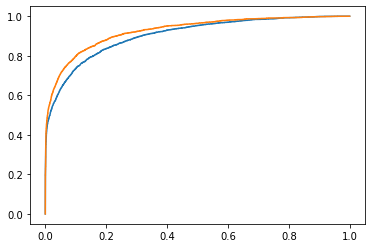

In [82]:
auc_dict = {}

for model_name,model in model_dict.items():
    
    if model_name == "feed forward":
        preds = model.predict(X_test)
    else:
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = model_name)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#plt.savefig("model_comparison.png", dpi=900,bbox_inches="tight")

**Let's build an RNN for this problem**

In [60]:
X2 = comment_df.text
y2 = comment_df.is_oh

X2_temp, X2_val, y2_temp, y2_val = train_test_split(X2,y2,train_size=0.8, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_temp,y2_temp, train_size = .75, test_size=.25, random_state =42)

In [61]:
seq_size = 15 
vocab_size = 2000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X2)

In [62]:
X2_train = tokenizer.texts_to_sequences(X2_train) 
X2_train = pad_sequences(X2_train, maxlen=seq_size)

X2_test = tokenizer.texts_to_sequences(X2_test)
X2_test = pad_sequences(X2_test, maxlen=seq_size)

In [ ]:
RNN = Sequential([
    #tokenizer,
    Embedding(
        input_dim=vocab_size,
        output_dim=5,
        mask_zero=True),
    Bidirectional(LSTM(5)),
    #SimpleRNN(30),
    
    #Dropout(.2),
    Dense(5, activation='relu'),
    Dense(1, activation="sigmoid")
])
##input_layer = Input(shape=(seq_size,)) 
#x = Embedding(vocab_size, 30)(input_layer) 
#x = SimpleRNN(30)(x) 
#x = Dense(10)(x)
#y = Dense(units=1, activation="sigmoid")(x)

#NN = Model(input_layer, y)
#NN.summary()

In [ ]:
RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_RNN = RNN.fit(X2_train, y2_train, validation_split=.5, class_weight = class_weights, epochs=20, verbose=1)

Epoch 1/20
1498/1498 [==============================] - 103s 64ms/step - loss: 0.7493 - accuracy: 0.8388 - val_loss: 0.3423 - val_accuracy: 0.8786
Epoch 2/20
1498/1498 [==============================] - 91s 61ms/step - loss: 0.5766 - accuracy: 0.8877 - val_loss: 0.3158 - val_accuracy: 0.8815
Epoch 3/20
1498/1498 [==============================] - 90s 60ms/step - loss: 0.5394 - accuracy: 0.8873 - val_loss: 0.3013 - val_accuracy: 0.8807
Epoch 4/20
1498/1498 [==============================] - 90s 60ms/step - loss: 0.5179 - accuracy: 0.8852 - val_loss: 0.3037 - val_accuracy: 0.8753
Epoch 5/20
1498/1498 [==============================] - 90s 60ms/step - loss: 0.5012 - accuracy: 0.8840 - val_loss: 0.3363 - val_accuracy: 0.8400
Epoch 6/20
1498/1498 [==============================] - 90s 60ms/step - loss: 0.4859 - accuracy: 0.8788 - val_loss: 0.2685 - val_accuracy: 0.8875
Epoch 7/20
1498/1498 [==============================] - 89s 60ms/step - loss: 0.4713 - accuracy: 0.8769 - val_loss: 0.2632 

In [ ]:
model_dict["RNN"] = RNN

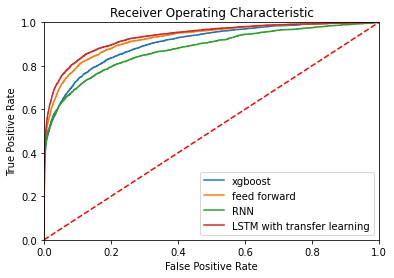

In [173]:
auc_dict = {}

for model_name,model in model_dict.items():
    
    if model_name == "RNN" or model_name == "LSTM with transfer learning":
        preds = model.predict(X2_test)
        fpr, tpr, threshold = metrics.roc_curve(y2_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
    else:
        if "LSTM" in model_name:
            continue
        if model_name == "feed forward":
            preds = model.predict(X_test)
        else:
            probs = model.predict_proba(X_test)
            preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = model_name)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("/content/drive/MyDrive/data/model_comparison.png", dpi=900,bbox_inches="tight")

In [ ]:
y2_pred = pd.DataFrame(LSTM_both.predict(X2_test), columns = ["val"]).val
y2_pred = (y2_pred.apply(lambda x: x > .2))
metrics.fbeta_score(y2_test,y2_pred,beta=2)

0.6461232604373758

In [ ]:
X2_val.shape

(31938,)

In [ ]:
RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 5)           10000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 10)               440       
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 5)                 55        
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________


In [11]:
import pickle

In [ ]:
with open("/content/drive/MyDrive/data/model_dict.p", 'wb') as handle:
    pickle.dump(model_dict, handle)

INFO:tensorflow:Assets written to: ram://91399c64-a577-41c9-bc80-77af15d17d3f/assets


INFO:tensorflow:Assets written to: ram://91399c64-a577-41c9-bc80-77af15d17d3f/assets


INFO:tensorflow:Assets written to: ram://bde4674b-9cd4-416c-9f24-d3eaa6bf3865/assets


INFO:tensorflow:Assets written to: ram://bde4674b-9cd4-416c-9f24-d3eaa6bf3865/assets


In [ ]:
with open("/content/drive/MyDrive/data/comment_df.p", 'wb') as handle:
    pickle.dump(comment_df,handle)

In [ ]:
with open("/content/drive/MyDrive/data/X.p", 'wb') as handle:
    pickle.dump(X, handle)

In [12]:
with open("/content/drive/MyDrive/data/comment_df.p", 'rb') as handle:
  comment_df = pickle.load(handle)

with open("/content/drive/MyDrive/data/model_dict.p", 'rb') as handle:
    model_dict = pickle.load(handle)

with open("/content/drive/MyDrive/data/X.p", 'rb') as handle:
    X = pickle.load(handle)

In [ ]:
model_dict


NameError: ignored

#Transfer learning

In [89]:
from gensim.models.keyedvectors import KeyedVectors

word_index = tokenizer.word_index

w2v_file = '/content/drive/MyDrive/data/GoogleNews-vectors-negative300.bin.gz'

word_vectors = KeyedVectors.load_word2vec_format(w2v_file, binary=True)



In [90]:
embedding_dim = 300 

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except: # word in our data vocab is missing in w2v, will use 0 vector for that word
        pass

In [ ]:
LSTM_transfer = Sequential([
    #tokenizer,
    Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(5)),
    #SimpleRNN(30),
    
    #Dropout(.2),
    Dense(5, activation='relu'),
    Dense(1, activation="sigmoid")
])

In [ ]:
LSTM_transfer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_transfer = LSTM_transfer.fit(X2_train, y2_train, validation_split=.2, class_weight = class_weights, epochs=5, verbose=1)

Epoch 1/5
2396/2396 [==============================] - 19s 7ms/step - loss: 0.6205 - accuracy: 0.8878 - val_loss: 0.2906 - val_accuracy: 0.8961
Epoch 2/5
2396/2396 [==============================] - 15s 6ms/step - loss: 0.5203 - accuracy: 0.9000 - val_loss: 0.2859 - val_accuracy: 0.8986
Epoch 3/5
2396/2396 [==============================] - 15s 6ms/step - loss: 0.4946 - accuracy: 0.9026 - val_loss: 0.2388 - val_accuracy: 0.9117
Epoch 4/5
2396/2396 [==============================] - 15s 6ms/step - loss: 0.4761 - accuracy: 0.9045 - val_loss: 0.2414 - val_accuracy: 0.9101
Epoch 5/5
2396/2396 [==============================] - 15s 6ms/step - loss: 0.4574 - accuracy: 0.9065 - val_loss: 0.2278 - val_accuracy: 0.9135


In [ ]:
model_dict["LSTM with transfer learning"] = LSTM_transfer

In [ ]:
inp = Input(shape=(seq_size,))

In [ ]:
emb_pre = Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix], 
              trainable=False)(inp)

emb_cus = Embedding(vocab_size, 40)(inp)

In [ ]:
embedding_dim_pre = 300
embedding_dim_custom = 40

inp = Input(shape=(seq_size,))
emb_pre = Embedding(len(word_index) + 1,
                    embedding_dim_pre,
                    weights=[embedding_matrix], 
                    trainable=False)(inp) 

emb_cus = Embedding(vocab_size, embedding_dim_custom)(inp) 

emb = Concatenate()([emb_pre, emb_cus])

x = Bidirectional(LSTM(5, recurrent_dropout = .3))(emb)
x = Dense(5, activation='relu')(x)
#x = Dropout(.3)(x)
y = Dense(1, activation='sigmoid')(x)


LSTM_both = Model(inp, y)

In [ ]:
LSTM_both.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = LSTM_both.fit(X2_train, y2_train, validation_split=.2, class_weight = class_weights, epochs=5, verbose=1)

Epoch 1/5
2396/2396 [==============================] - 212s 87ms/step - loss: 0.5878 - accuracy: 0.8900 - val_loss: 0.2468 - val_accuracy: 0.9203
Epoch 2/5
2396/2396 [==============================] - 209s 87ms/step - loss: 0.4650 - accuracy: 0.9042 - val_loss: 0.2170 - val_accuracy: 0.9232
Epoch 3/5
2396/2396 [==============================] - 209s 87ms/step - loss: 0.4176 - accuracy: 0.9065 - val_loss: 0.2330 - val_accuracy: 0.9079
Epoch 4/5
2396/2396 [==============================] - 209s 87ms/step - loss: 0.3768 - accuracy: 0.9093 - val_loss: 0.2246 - val_accuracy: 0.9097
Epoch 5/5
2396/2396 [==============================] - 209s 87ms/step - loss: 0.3386 - accuracy: 0.9149 - val_loss: 0.2552 - val_accuracy: 0.8954


In [ ]:
model_dict["LSTM combined"] = LSTM_both

In [ ]:
with open("/content/drive/MyDrive/data/model_dict.p", 'wb') as handle:
    pickle.dump(model_dict, handle)

Pretrained embedding and combined pretrained with custom embeddings performed very similar. 

But the transfer learning definitely outperforms the other RNNs.

So we'll now train a more complex RNN with transfer learning (only the pretrained embedding)

In [94]:
LSTM_comp= Sequential([
    Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(100)),
    
    Dropout(.3),
    Dense(50, activation='relu'),
    Dropout(.3),
    Dense(20, activation='relu'),
    Dropout(.3),
    Dense(1, activation="sigmoid")
])

In [95]:
LSTM_comp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [96]:
LSTM_comp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         62041200  
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                10050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                      

In [97]:
history_comp = LSTM_comp.fit(X2_train, y2_train, validation_split=.2, class_weight = class_weights, epochs=20, verbose=1)

Epoch 1/20
2396/2396 [==============================] - 24s 9ms/step - loss: 0.6043 - accuracy: 0.8868 - val_loss: 0.2829 - val_accuracy: 0.9079
Epoch 2/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.5256 - accuracy: 0.8993 - val_loss: 0.4200 - val_accuracy: 0.8154
Epoch 3/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.4901 - accuracy: 0.9028 - val_loss: 0.2835 - val_accuracy: 0.8908
Epoch 4/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.4484 - accuracy: 0.9037 - val_loss: 0.2464 - val_accuracy: 0.9106
Epoch 5/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.4091 - accuracy: 0.9046 - val_loss: 0.2731 - val_accuracy: 0.8743
Epoch 6/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.3626 - accuracy: 0.9061 - val_loss: 0.2372 - val_accuracy: 0.9023
Epoch 7/20
2396/2396 [==============================] - 18s 7ms/step - loss: 0.3172 - accuracy: 0.9197 - val_loss: 0.2507 - val_ac

In [ ]:
model_dict["LSTM complex"] = LSTM_comp

with open("/content/drive/MyDrive/data/model_dict.p", 'wb') as handle:
    pickle.dump(model_dict, handle)

INFO:tensorflow:Assets written to: ram://c7796c62-3398-4e44-abf6-8f45b8d368fc/assets


INFO:tensorflow:Assets written to: ram://c7796c62-3398-4e44-abf6-8f45b8d368fc/assets


INFO:tensorflow:Assets written to: ram://99a6c7ed-53d7-4bba-b89f-06e2673217fa/assets


INFO:tensorflow:Assets written to: ram://99a6c7ed-53d7-4bba-b89f-06e2673217fa/assets


INFO:tensorflow:Assets written to: ram://15fec592-787f-425f-afef-ea54ea553ba5/assets


INFO:tensorflow:Assets written to: ram://15fec592-787f-425f-afef-ea54ea553ba5/assets


INFO:tensorflow:Assets written to: ram://ee14b0b9-38f5-4e66-ac93-65047ea76b06/assets


INFO:tensorflow:Assets written to: ram://ee14b0b9-38f5-4e66-ac93-65047ea76b06/assets


INFO:tensorflow:Assets written to: ram://88b50e9d-d34f-479e-8a86-e06f284491ff/assets


INFO:tensorflow:Assets written to: ram://88b50e9d-d34f-479e-8a86-e06f284491ff/assets


In [102]:
LSTM_comp2= Sequential([
    Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(100)),
    
    Dropout(.3),
    Dense(50, activation='relu'),
    Dense(1, activation="sigmoid")
])

In [103]:
LSTM_comp2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
history_comp2 = LSTM_comp2.fit(X2_train, y2_train, validation_split=.2,  class_weight = class_weights, epochs=20, verbose=1)

Epoch 1/20
2396/2396 [==============================] - 21s 8ms/step - loss: 0.0582 - accuracy: 0.9872 - val_loss: 0.4058 - val_accuracy: 0.9381
Epoch 2/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0298 - accuracy: 0.9937 - val_loss: 0.4359 - val_accuracy: 0.9383
Epoch 3/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0346 - accuracy: 0.9930 - val_loss: 0.4504 - val_accuracy: 0.9369
Epoch 4/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0313 - accuracy: 0.9934 - val_loss: 0.4571 - val_accuracy: 0.9372
Epoch 5/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0268 - accuracy: 0.9939 - val_loss: 0.5113 - val_accuracy: 0.9345
Epoch 6/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0282 - accuracy: 0.9942 - val_loss: 0.5069 - val_accuracy: 0.9335
Epoch 7/20
2396/2396 [==============================] - 19s 8ms/step - loss: 0.0314 - accuracy: 0.9935 - val_loss: 0.4509 - val_ac

In [ ]:
model_dict["LSTM complex 2"] = LSTM_comp2

with open("/content/drive/MyDrive/data/model_dict.p", 'wb') as handle:
    pickle.dump(model_dict, handle)

INFO:tensorflow:Assets written to: ram://2a2121fa-2be8-45bd-b061-5c8b654bd397/assets


INFO:tensorflow:Assets written to: ram://2a2121fa-2be8-45bd-b061-5c8b654bd397/assets


INFO:tensorflow:Assets written to: ram://51564610-4ff9-45c1-ac7e-46927dbb0598/assets


INFO:tensorflow:Assets written to: ram://51564610-4ff9-45c1-ac7e-46927dbb0598/assets


INFO:tensorflow:Assets written to: ram://c2d0dcab-a43f-4c62-9e53-17b863c80722/assets


INFO:tensorflow:Assets written to: ram://c2d0dcab-a43f-4c62-9e53-17b863c80722/assets


INFO:tensorflow:Assets written to: ram://faac2e37-6fa9-4373-bc2a-37ebbaa08891/assets


INFO:tensorflow:Assets written to: ram://faac2e37-6fa9-4373-bc2a-37ebbaa08891/assets


INFO:tensorflow:Assets written to: ram://4d81ecdd-66db-472e-9da0-89a5f49a3009/assets


INFO:tensorflow:Assets written to: ram://4d81ecdd-66db-472e-9da0-89a5f49a3009/assets


INFO:tensorflow:Assets written to: ram://c525e02c-e0e9-4feb-a5d0-70cfe8c6dbcb/assets


INFO:tensorflow:Assets written to: ram://c525e02c-e0e9-4feb-a5d0-70cfe8c6dbcb/assets


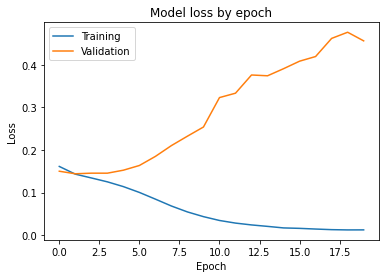

In [106]:
plt.plot(history_comp.history['loss'])
plt.plot(history_comp.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

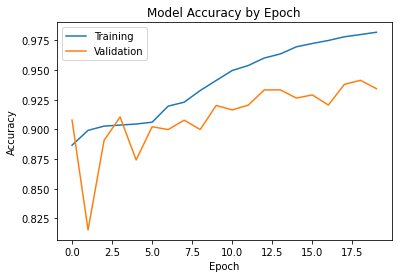

<Figure size 432x288 with 0 Axes>

In [174]:
plt.plot(history_comp.history['accuracy'])
plt.plot(history_comp.history['val_accuracy'])
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.savefig("/content/drive/MyDrive/data/model_accuracy.png", dpi=900,bbox_inches="tight")

#Scattertext visualization

In [54]:
nlp = spacy.load("en")

#pf = ProfanityFilter(nlps={'en': nlp})
#nlp.add_pipe(pf.spacy_component, last=True)

In [55]:
youtube_df["cat"] = youtube_df.is_oh.apply(lambda x: "Online Harassment" if x else "Not Online Harassment")

In [56]:
corpus = st.CorpusFromPandas(youtube_df, category_col = "cat", text_col = "text", nlp = nlp).build()

In [45]:
html = st.produce_scattertext_explorer(corpus, category = "Online Harassment", width_in_pixels=1000, minimum_term_frequency=11)

In [57]:
open("/content/drive/MyDrive/data/scattertext.html", "w").write(html)

5732737

Get F2-scores for all models

In [128]:
f2_dict = {}

In [143]:
for model_name, model in model_dict.items():
  if "LSTM" in model_name or model_name == "RNN":
    y2_pred = pd.DataFrame(model.predict(X2_test), columns = ["val"]).val
    y2_pred = (y2_pred.apply(lambda x: x > .2))
    f2_dict[model_name] = metrics.fbeta_score(y2_test,y2_pred,beta=2)

  elif model_name == "feed forward":
    y_pred = pd.DataFrame(model.predict(X_test), columns = ["val"]).val
    y_pred = (y_pred.apply(lambda x: x > .2))
    f2_dict[model_name] = metrics.fbeta_score(y_test,y_pred,beta=2)

In [144]:
f2_dict

{'LSTM combined': 0.6461232604373758,
 'LSTM complex': 0.7013286416307711,
 'LSTM complex 2': 0.6938801025192224,
 'LSTM with transfer learning': 0.6526624776406916,
 'RNN': 0.5967519169405153,
 'feed forward': 0.6867350723204351}

In [145]:
youtube_val = tokenizer.texts_to_sequences(youtube_df.text) 
youtube_val = pad_sequences(youtube_val, maxlen=seq_size)

In [167]:
model = model_dict["LSTM complex"]
y2_pred = pd.DataFrame(model.predict(youtube_val), columns = ["val"]).val
y2_pred = (y2_pred.apply(lambda x: x > .2))
metrics.fbeta_score(youtube_df.is_oh,y2_pred,beta=2)

0.32141629425919555

In [168]:
from sklearn.metrics import confusion_matrix

In [169]:
tn, fp, fn, tp  = confusion_matrix(youtube_df.is_oh,y2_pred).ravel()

In [170]:
print("Confusion matrix for YouTube data")

print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)
print("True positive:", tp)

Confusion matrix for YouTube data
True negative: 1993
False positive: 1054
False negative: 230
True positive: 187


In [161]:
model = model_dict["LSTM complex"]
y2_pred = pd.DataFrame(model.predict(X2_test), columns = ["val"]).val
y2_pred = (y2_pred.apply(lambda x: x > .2))

0.7013286416307711

In [165]:
tn, fp, fn, tp  = confusion_matrix(y2_test,y2_pred).ravel()

print("Confusion matrix for all comment data")

print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)
print("True positive:", tp)

Confusion matrix for all comment data
True negative: 27138
False positive: 1675
False negative: 812
True positive: 2312


In [171]:
comment_df.shape

(159686, 4)

In [172]:
youtube_df.shape

(3464, 3)